<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_03_05_survival_analysis_generalized_gamma_model_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 3.5 Generalized Gamma Survival Model

Generalized Gamma Survival Model is a flexible parametric model that encompasses several common survival distributions as special cases. This tutorial provides an overview of the generalized gamma model, its properties, and how to implement it in R using the `flexsurv` package. We will use the `lung` dataset from the `survival` package for demonstration.

### Overview


The **Generalized Gamma (GG) survival model** is a highly flexible parametric model in survival analysis that generalizes several other models, including the exponential, Weibull, log-normal, and gamma distributions. It is characterized by three parameters, allowing it to model a wide range of hazard shapes (monotonic increasing, decreasing, arc-shaped, or bathtub-shaped). This makes it suitable for complex survival data where simpler models (e.g., exponential or log-normal) may not fit well. The GG model can be used in an Accelerated Failure Time (AFT) framework, where covariates scale the survival time, or in other parameterizations depending on the software.


### Key Features


- **Flexibility**: The GG model’s three parameters allow it to capture diverse hazard behaviors, including those of the exponential ($p = q = 1$), Weibull ($q = 1$), log-normal ($q\to \infty$), and standard gamma ($p = q$).
- **Applications**: Used in medical research (e.g., survival after treatment), reliability engineering (e.g., component failure times), and economics (e.g., duration models) when hazard shapes are complex or unknown.
- **Assumptions**: Assumes survival times $T$ follow a generalized gamma distribution, with log-times having a flexible distribution controlled by shape parameters.
- **Advantages**: Encompasses multiple models, reducing the need to test several distributions. Can model non-monotonic hazards (e.g., bathtub-shaped for infant mortality followed by aging).
- **Limitations**: Computationally intensive due to three parameters. Parameter estimation can be unstable with small datasets or misspecified models. Less intuitive interpretation compared to simpler models.


The generalized gamma distribution has three parameters: $\mu$ (location, related to the mean of log-time), $\sigma > 0$ (scale, controlling dispersion), and $q$ (shape, affecting hazard shape). Alternatively, it is often parameterized with a scale parameter $\lambda = \exp(-\mu/\sigma)$ and shape parameters $p = 1/(\sigma q).

- **Probability Density Function (PDF)**:
$$
  f(t) = \frac{p \lambda (p t)^{pq - 1} e^{-(p t)^q}}{\Gamma(p)}, \quad t > 0, \quad \lambda, p, q > 0
$$

where $\Gamma$ is the gamma function, $p = 1/(\sigma q)$, and $\lambda = \exp(-\mu/\sigma)$. The PDF is complex but reduces to simpler forms (e.g., Weibull when $q = 1$).

- **Survival Function**:

$$
  S(t) = 1 - \frac{\gamma(p, (p t)^q)}{\Gamma(p)}
$$

 where $\gamma(p, x) = \int_0^x u^{p-1} e^{-u} \, du $ is the incomplete gamma function. This gives the probability of surviving past time $t$.

- **Hazard Function**:

$$
  h(t) = \frac{f(t)}{S(t)} = \frac{p \lambda (p t)^{pq - 1} e^{-(p t)^q}}{\Gamma(p) - \gamma(p, (p t)^q)}
$$
  The hazard shape depends on $p$ and $q$:
  
  - $p > 1, q > 1$: Arc-shaped (increases then decreases).
  - $p < 1, q < 1$: Bathtub-shaped (decreases, then increases).
  - $q = 1$: Weibull-like (monotonic increasing or decreasing).

- **Mean and Variance**:

  - Mean: $E[T] = \frac{\exp(\mu) \Gamma(p + 1/q)}{\Gamma(p)}$, if $p + 1/q > 0$.
  - Variance: Complex, involving higher-order gamma functions.
  - Note: Mean may be undefined for certain parameter values.


### When to Use


Choose the generalized gamma model when:
- Nonparametric hazard estimates (e.g., from Kaplan-Meier) show complex shapes (arc-shaped, bathtub-shaped, or non-monotonic).
- You want to test multiple parametric models within one framework (e.g., exponential, Weibull, log-normal).
- Flexibility is needed, but you’re willing to handle computational complexity.


### Model Fit Assessment


- Use AIC/BIC to compare with simpler models (e.g., Weibull, log-normal, log-logistic).
- Check residuals (e.g., Cox-Snell) or compare fitted survival curves to Kaplan-Meier estimates.
- Validate parameter estimates with Q-Q plots or hazard shape diagnostics.


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316565 sha256=7030c337528ee13f0160bc0d6cedab9637c8858ee7ab32daf8c6b68aa0f3f45b
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Implementation in R


This tutorial demonstrates fitting a generalized gamma survival model using R’s `flexsurv` package, as the `survival` package’s `survreg` does not support the generalized gamma distribution directly. We’ll use the `lung` dataset from `survival`, consistent with your previous queries. The code includes data preparation, model fitting, predictions, plotting, and diagnostics, addressing lessons from prior errors (e.g., `Invalid status value`, `psurvreg`, `lines`, and plotting issues).


### Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:


In [ ]:
%%R
packages <-c(
		 'tidyverse',
		 'survival',
		 'flexsurv',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'condSURV',
		 'riskRegression'
		 )


### Install missing packages

In [ ]:
%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')

### Verify installation

In [ ]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method        from 
  nobs.multinom broom



     tidyverse       survival       flexsurv      survminer      ggsurvfit 
          TRUE           TRUE           TRUE           TRUE           TRUE 
    tidycmprsk      ggfortify        timereg         cmprsk       condSURV 
          TRUE           TRUE           TRUE           TRUE           TRUE 
riskRegression 
          TRUE 


### Load Packages

In [ ]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
     tidyverse       survival       flexsurv      survminer      ggsurvfit 
          TRUE           TRUE           TRUE           TRUE           TRUE 
    tidycmprsk      ggfortify        timereg         cmprsk       condSURV 
          TRUE           TRUE           TRUE           TRUE           TRUE 
riskRegression 
          TRUE 


In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

### Data Loading and Cleaning

In [ ]:
%%R
# Load dataset properly
library(survival) # Load the survival package
data("lung", package = "survival")

# Recode status: 1=censored (0), 2=dead (1)
lung$status <- lung$status - 1

# Clean data
lung_clean <- lung[!is.na(lung$time) & !is.na(lung$status) &
                   !is.na(lung$age) & !is.na(lung$sex) &
                   lung$time > 0 & lung$status %in% c(0, 1), ]
print(dim(lung_clean))

[1] 228  10


### Data Preparation

In [ ]:
%%R
# Create survival object explicitly for right-censored data
surv_object <- Surv(time = lung_clean$time, event = lung_clean$status)
print("Structure of Surv object:")
str(surv_object)

[1] "Structure of Surv object:"
 'Surv' num [1:228, 1:2]  306   455  1010+  210   883  1022+  310   361   218   166  ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "time" "status"
 - attr(*, "type")= chr "right"


### Model Fitting

In [ ]:
%%R
library(flexsurv) # Load the flexsurv package
# Fit generalized gamma models with initial estimates
gg_model <- flexsurvreg(surv_object ~ 1, data = lung_clean, dist = "gengamma")

gg_model_cov <- flexsurvreg(surv_object ~ age + sex, data = lung_clean, dist = "gengamma",
              inits = c(5, 0.5, 0, 0, 0))
print("Model summary (with covariates):")
summary(gg_model_cov)

[1] "Model summary (with covariates):"
age=62.4473684210526,sex=1.39473684210526 
    time        est        lcl        ucl
1      5 0.99728351 0.99299960 0.99948626
2     11 0.99222791 0.98360413 0.99755851
3     12 0.99127383 0.98186365 0.99714254
4     13 0.99029362 0.98019134 0.99665711
5     15 0.98826055 0.97713518 0.99557273
6     26 0.97567993 0.95860676 0.98820989
7     30 0.97063481 0.95160185 0.98500194
8     31 0.96934096 0.94977785 0.98413294
9     53 0.93828260 0.90995162 0.96029393
10    54 0.93677455 0.90811863 0.95903940
11    59 0.92913450 0.89923009 0.95282494
12    60 0.92758757 0.89726832 0.95158525
13    61 0.92603465 0.89553775 0.95033576
14    62 0.92447589 0.89380732 0.94907662
15    65 0.91976583 0.88854703 0.94524208
16    71 0.91020472 0.87728127 0.93730909
17    79 0.89719938 0.86241408 0.92636293
18    81 0.89390750 0.85826760 0.92349570
19    88 0.88227440 0.84485183 0.91378887
20    92 0.87555692 0.83787262 0.90789548
21    93 0.87387037 0.83590997 0.906

### Predictions

In [ ]:
%%R
# Prediction for new data (60-year-old male)
new_data <- data.frame(age = 60 - mean(lung_clean$age), sex = 1)
median_time <- predict(gg_model_cov, newdata = new_data, type = "survival")[[1]]
print("Median survival time (days):")
print(median_time)

[1] "Median survival time (days):"
[[1]]
# A tibble: 228 × 2
   .eval_time .pred_survival
        <dbl>          <dbl>
 1          5          0.999
 2         11          0.996
 3         11          0.996
 4         11          0.996
 5         12          0.996
 6         13          0.996
 7         13          0.996
 8         15          0.995
 9         26          0.989
10         30          0.987
# ℹ 218 more rows
# ℹ Use `print(n = ...)` to see more rows



### Survival Probability

[1] "Survival probability at t=500 days:"
NULL


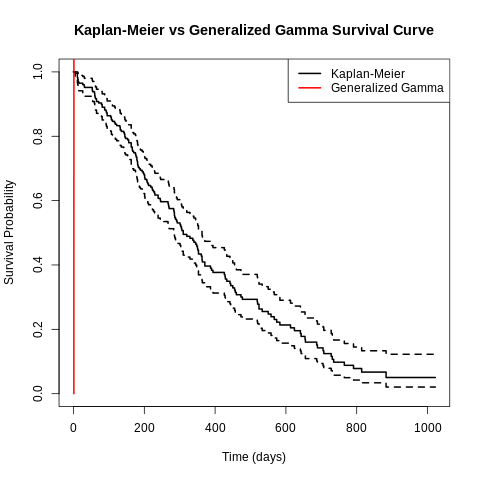

In [ ]:
%%R
# Survival probability at t=500 days
surv_prob <- summary(gg_model_cov, newdata = new_data, type = "survival", t = 500)$est
print("Survival probability at t=500 days:")
print(surv_prob)

# Plot Kaplan-Meier and generalized gamma curve (null model)
km_fit <- survfit(surv_object ~ 1)
plot(km_fit, main = "Kaplan-Meier vs Generalized Gamma Survival Curve",
     xlab = "Time (days)", ylab = "Survival Probability",
     col = "black", lwd = 2)
t_seq <- seq(0, max(lung_clean$time), length.out = 100)
surv_gg <- summary(gg_model, t = t_seq, type = "survival")$est
lines(t_seq, surv_gg, col = "red", lwd = 2)
legend("topright", c("Kaplan-Meier", "Generalized Gamma"), col = c("black", "red"), lwd = 2)

### Model Diagnostics

#### Cox-Snell Residuals

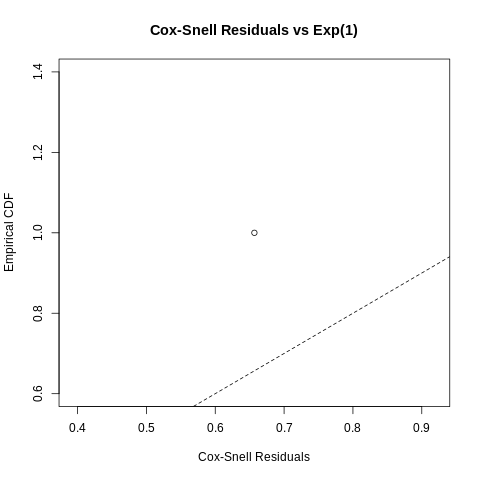

In [ ]:
%%R

# Compute survival probabilities for each individual time
surv_list <- summary(gg_model_cov, t = lung_clean$time, type = "survival")

# Extract 'est' column from each list element
surv_probs <- sapply(surv_list, function(x) x$est[1])

# Compute Cox–Snell residuals
residuals_cs <- -log(surv_probs)
# 2. Cox-Snell Residuals
valid <- is.finite(residuals_cs)
residuals_cs <- residuals_cs[valid]

# Plot Cox-Snell residuals
plot(sort(residuals_cs), (1:length(residuals_cs))/length(residuals_cs),
     main = "Cox-Snell Residuals vs Exp(1)",
     xlab = "Cox-Snell Residuals", ylab = "Empirical CDF")
lines(sort(residuals_cs), pexp(sort(residuals_cs)), col = "red", lwd = 2)
abline(0, 1, lty = 2)


#### Model Comparison

In [ ]:
%%R
# 3. Goodness-of-Fit: Compare with Weibull and Log-Normal
weibull_model_cov <- flexsurvreg(surv_object ~ age + sex, data = lung_clean, dist = "weibull")
lnorm_model_cov <- flexsurvreg(surv_object ~ age + sex, data = lung_clean, dist = "lnorm")
print("AIC Comparison:")
print(AIC(gg_model_cov, weibull_model_cov, lnorm_model_cov))

[1] "AIC Comparison:"
                  df      AIC
gg_model_cov       5 2304.117
weibull_model_cov  4 2302.109
lnorm_model_cov    4 2325.500


#### Hazard Function

In [ ]:
%%R

# 4. Hazard Plot (for new_data)
haz_gg <- summary(gg_model_cov, newdata = new_data, type = "hazard", t = t_seq, tidy = TRUE)
ggplot(haz_gg, aes(x = time, y = est)) +
  geom_line(col = "blue", lwd = 1) +
  ggtitle("Generalized Gamma Hazard Function (for new data)") +
  xlab("Time (days)") + ylab("Hazard Rate")

## Summary and Conclusion


The generalized gamma survival model is a powerful and flexible tool in survival analysis, capable of modeling a wide range of hazard shapes through its three parameters. It encompasses several common distributions, making it a versatile choice when the underlying hazard function is complex or unknown. However, its complexity can lead to computational challenges and interpretability issues, especially with small datasets. Model fit should be carefully assessed using AIC/BIC, residual analysis, and visual diagnostics to ensure the chosen model adequately represents the data.


## Resources


- **R Documentation**:
  - `survreg`: [https://rdrr.io/r/stats/survreg.html](https://rdrr.io/r/stats/survreg.html)
  - `flexsurvreg`: [https://cran.r-project.org/web/packages/flexsurv/flexsurv.pdf](https://cran.r-project.org/web/packages/flexsurv/flexsurv.pdf)
- **Books**:
  - "Survival Analysis: Techniques for Censored and Truncated Data" by Klein & Moeschberger
  - "Applied Survival Analysis" by Hosmer, Lemeshow, & May
- **Tutorials**:
  - UCLA IDRE Survival Analysis with R: [https://stats.idre.ucla.edu/r/seminars/survival-analysis-with-r/](https://stats.idre.ucla.edu/r/seminars/survival-analysis-with-r/)
  - R-bloggers: [https://www.r-bloggers.com/](https://www.r-bloggers.com/)
- **Online Courses**:
  - Coursera: "Survival Analysis in R" by Duke University
  - edX: "Survival Analysis" by Harvard University
```


In [ ]:
%%R
# remove all objects from the environment
rm(list = ls())